# Mixtral 8x7B

reference [MEGABLOCKS: EFFICIENT SPARSE TRAINING WITH MIXTURE-OF-EXPERTS](https://arxiv.org/pdf/2211.15841.pdf)

a high-quality structured sparse mixture of experts model(SMoE) with open weights.

Mixtral outperforms Llama 2 70B on most benchmarks with 6x faster inference.

capabilities:
- 32k context tokens support
- multi language
- strong performance in code generation


SMoE: picks from a set of 8 distinct groups of parameters when forwarding. At every layer, every token, a router network choose two of these groups(the "experts") to process the token and tombine their output additively. Incresing the number of parameters of a model while controling cost and latency as the model only uses a fractio of the total set of parameters per-token.

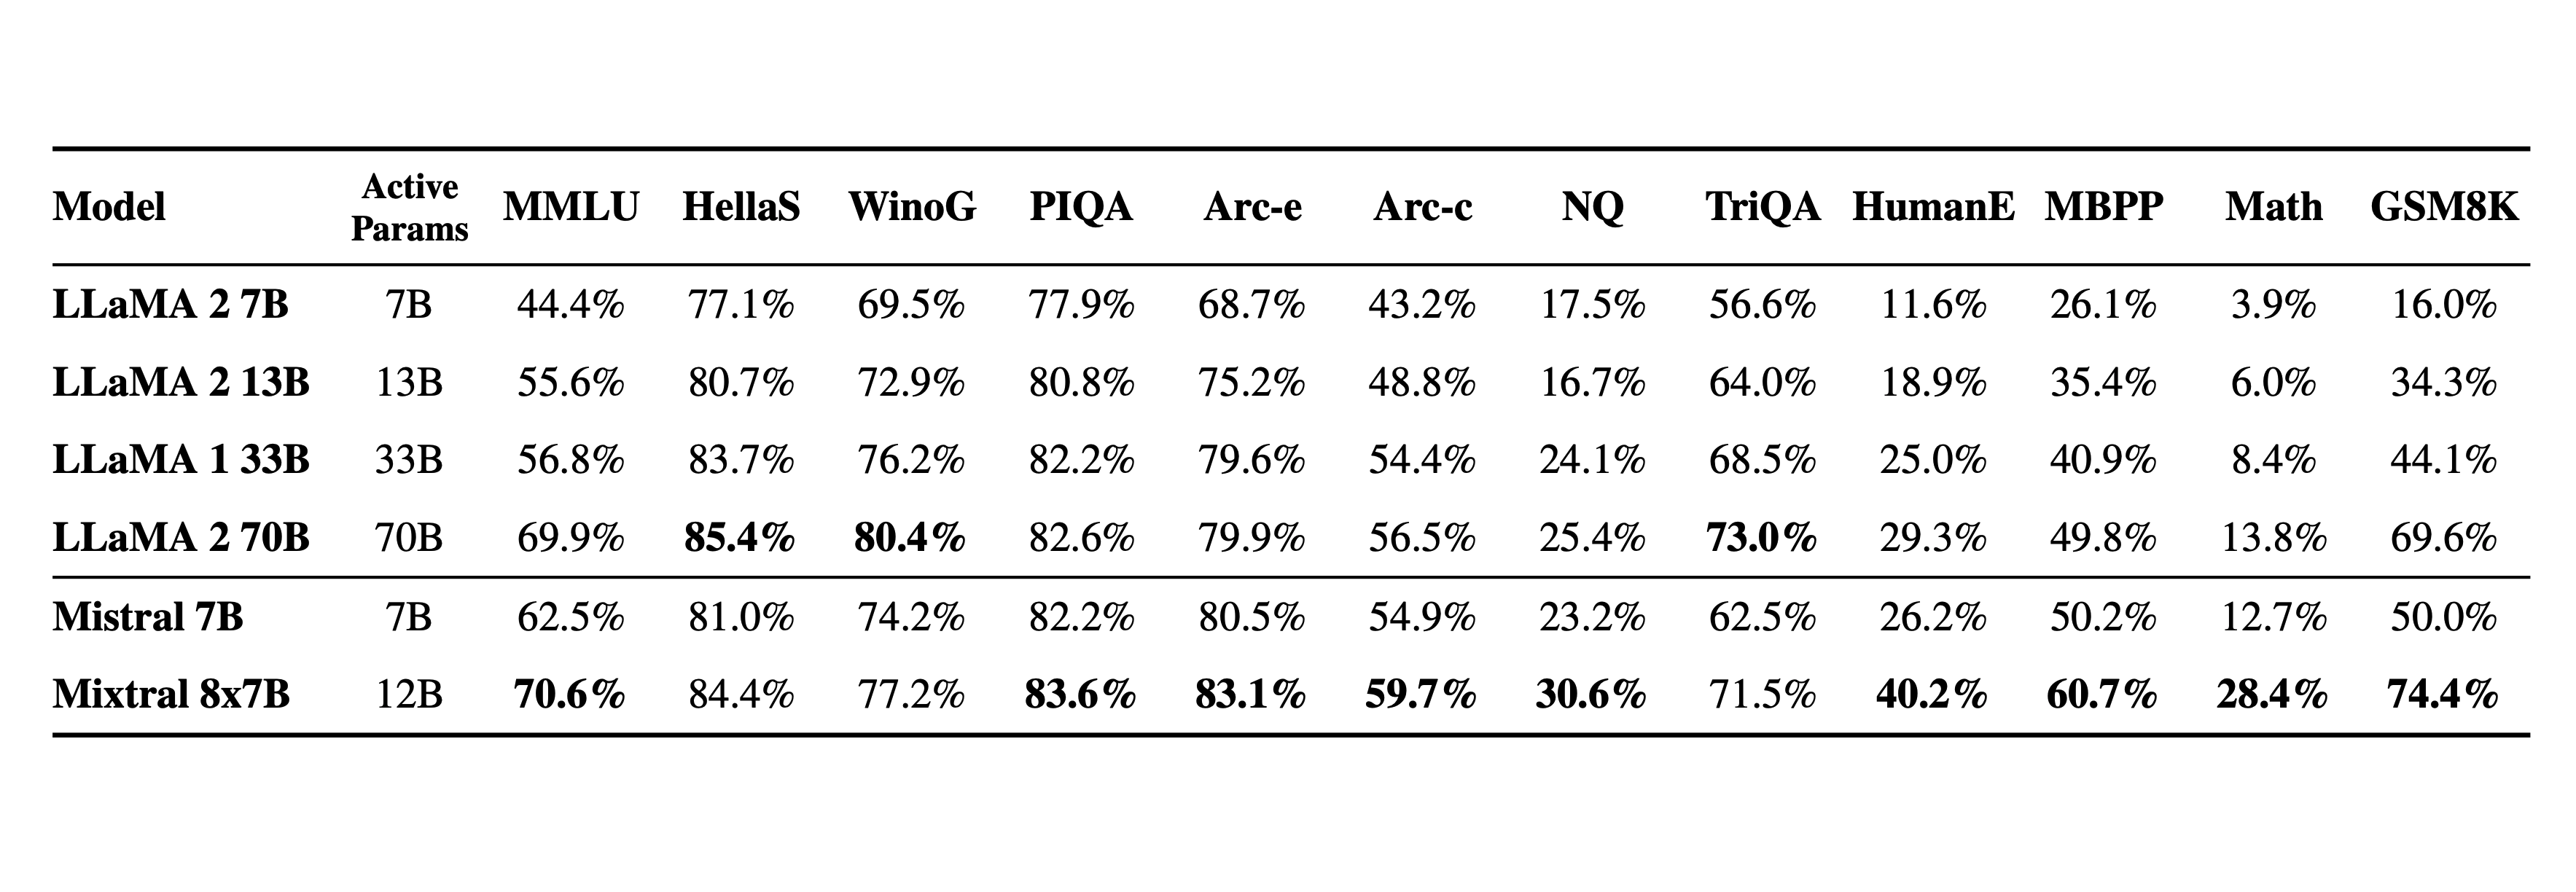


```shell
MixtralForCausalLM
    model:          MixtralModel
        embed_tokens:   nn.Embedding
        layers:         nn.ModuleList[MixtralDecoderLayer]
            self_attn:                  MixtralAttention/MixtralFlashAttention2
                q_proj:                 nn.Linear
                k_proj:                 nn.Linear
                v_proj:                 nn.Linear
                rotary_emb:             MixtralRotaryEmbedding
                o_proj:                 nn.Linear
            block_sparse_moe:           MixtralSparseMoeBlock
                num_experts
                top_k = num_experts_per_tok
                experts:                nn.ModuleList[MixtralBLockSparseTop2MLP]
                    act_fn:             silu
                    w1:                 nn.Linear
                    w2:                 nn.Linear
                    w3:                 nn.Linear
                gate:                   nn.Linear
            input_layernorm:            MixtralRMSNorm
            post_attention_layernorm:   MixtralRMSNorm
        norm:           MixtralRMSNorm
    num_experts
    num_experts_per_tok


```
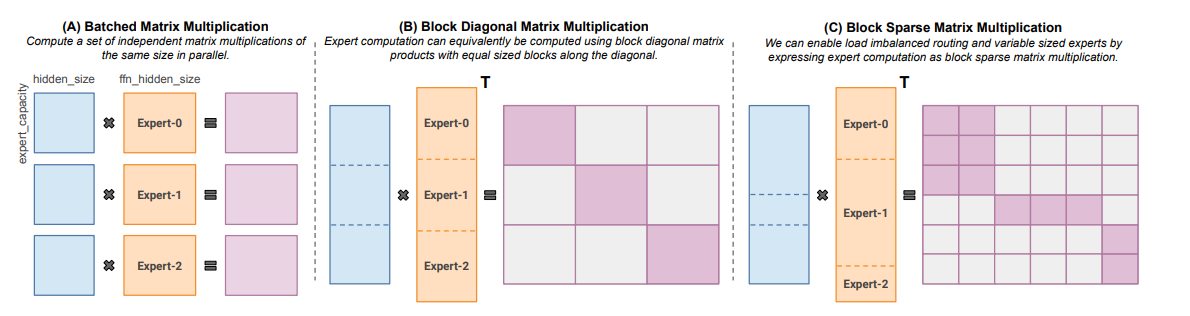

Mixtral 拥有正常的self_attn layer，和正常网络不同的是mlp layer 包含了门控选择专家组以及多个专家。

而MLP层则是MixtralSparseMoeBlock，8名专家每次在forward的时候，由gate选择其中的2名专家推理，这两名专家也是擅长于此token的住哪家。而其他的专家等于置0，等价于结构稀疏。


In [34]:
# routing testing

import torch
import torch.nn.functional as F
SEED = 42
torch.manual_seed(SEED)

hidden_size = 32
seq_len = 1
batch_size = 1
num_experts = 8
num_experts_per_tok = 2

hidden_states = torch.randn(batch_size, seq_len, hidden_size, dtype=torch.float16).cuda()
device = hidden_states.device
gate_weight = torch.randn(hidden_size, num_experts, dtype=torch.float16).cuda()

experts = [
    torch.randn(hidden_size, hidden_size, dtype=torch.float16).cuda() for _ in range(num_experts)
]

def routing_forward(x: torch.Tensor):
    x = x.view(-1, hidden_size)
    router_logits = F.linear(x, gate_weight.T)
    routing_weights = F.softmax(router_logits, dim=1, dtype=torch.float)
    # print(routing_weights.shape, routing_weights)
    routing_weights, selected_experts = torch.topk(routing_weights, num_experts_per_tok, dim=-1)
    routing_weights /= routing_weights.sum(dim=-1, keepdim=True)
    # print(routing_weights, selected_experts, )
    routing_weights = routing_weights.to(x.dtype)
    final_hidden_states = torch.zeros((batch_size * seq_len, hidden_size), dtype=x.dtype, device=x.device)
    expert_mask = F.one_hot(selected_experts, num_classes=num_experts).permute(2, 1, 0)
    # print(expert_mask.shape, F.one_hot(selected_experts, num_classes=num_experts))
    for expert_idx in range(num_experts):
        expert = experts[expert_idx]
        idx, top_x = torch.where(expert_mask[expert_idx])
        if top_x.shape[0] == 0:
            continue
        top_x_list = top_x.tolist()
        idx_list = idx.tolist()
        print(expert_idx, top_x, idx_list)
        current_state = x[None, top_x_list].reshape(-1, hidden_size)
        # print(expert_idx, top_x_list, current_state.shape)
        current_hidden_states = F.linear(current_state, expert)
        current_hidden_states = routing_weights[top_x_list, idx_list, None] * current_hidden_states
        final_hidden_states.index_add_(0, top_x, current_hidden_states.to(hidden_states.dtype))
    final_hidden_states = final_hidden_states.reshape(batch_size, seq_len, hidden_size)
    return final_hidden_states, router_logits



final_hidden_states, router_logits = routing_forward(hidden_states)
print(final_hidden_states.shape, router_logits.shape)


2 tensor([0], device='cuda:0') [1]
3 tensor([0], device='cuda:0') [0]
torch.Size([1, 1, 32]) torch.Size([1, 8])
